In [1]:
!pip install tensorflow datasets tqdm typing-extensions==4.11.0 --quiet

# 2. IMPORT LIBRARIES
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, LeakyReLU
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
from datasets import load_dataset
from tqdm.auto import tqdm
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.2/69.2 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 96.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 68.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 70.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 106.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 101.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27

In [2]:
CONFIG = {
    "image_size": (128, 128),
    "batch_size": 64,
    "epochs": 30,
    "num_train_samples": 5000,
    "num_test_samples": 1000,
    "learning_rate": 3e-4,
    "weight_decay": 1e-4,
    "early_stop_patience": 10,
    "lr_patience": 5,

}

In [5]:
def preprocess_image(sample):
    """Preprocess images for TensorFlow Dataset"""
    img = sample['image'].convert("RGB")
    img = img.resize(CONFIG["image_size"])

    img_array = np.array(img, dtype=np.float32) / 255.0

    return img_array, sample['label']

def load_data_generator(split, le, batch_size=CONFIG["batch_size"]):
    """Loads data as a generator using streaming"""
    dataset = load_dataset("GVJahnavi/PlantVillage_dataset", split=split, streaming=True)

    images, labels = [], []
    count = 0  # Track the number of samples processed

    for sample in tqdm(dataset, desc=f"Loading {split}"):
        try:
            img_array, label = preprocess_image(sample)

            # Ensure image has correct shape (128, 128, 3)
            if img_array.shape != (CONFIG["image_size"][0], CONFIG["image_size"][1], 3):
                print(f"Skipping image with wrong shape: {img_array.shape}")
                continue

            images.append(img_array)
            labels.append(label)
            count += 1

            # Yield batch
            if len(images) == batch_size:
                yield np.array(images), le.transform(np.array(labels))
                images, labels = [], []  # Reset batch

        except Exception as e:
            print(f"Skipping image due to error: {e}")
            continue

    # Yield last batch if exists
    if images:
        yield np.array(images), le.transform(np.array(labels))  # Encode labels

In [6]:
# ==============================================
# Data Loading
# ==============================================
print("Loading data...")

# Initialize LabelEncoder
le = LabelEncoder()

# Collect all labels to encode them
all_labels = []
dataset = load_dataset("GVJahnavi/PlantVillage_dataset", split="train", streaming=True)
for sample in tqdm(dataset, desc="Collecting labels"):
    try:
        _, label = preprocess_image(sample)
        all_labels.append(label)
    except Exception as e:
        print(f"Skipping label due to error: {e}")
        continue

le.fit(all_labels)  # Fit on all labels

# Split labels for train and test
train_labels = all_labels[:len(all_labels)//2]
test_labels = all_labels[len(all_labels)//2:]

# Compute class weights
y_train = le.transform(train_labels)
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

# Initialize generators and consume them to load data
train_generator = list(load_data_generator("train", le))
test_generator = list(load_data_generator("test", le))


print("Data loading complete.")


Loading data...


Loading train: 0it [00:00, ?it/s]

Loading test: 0it [00:00, ?it/s]

Data loading complete.


In [7]:
# ==============================================
# Data Augmentation
# ==============================================
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,  # Added vertical flip
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator()


In [8]:
# ==============================================
# Enhanced Model Architecture
# ==============================================
def build_model():
    model = Sequential()
    input_shape = (*CONFIG["image_size"], 3)

    # Conv Blocks
    filters = [32, 64, 128, 256]
    dropouts = [0.25, 0.3, 0.4, 0.5]

    for i, (f, dr) in enumerate(zip(filters, dropouts)):
        # First block has input_shape
        if i == 0:
            model.add(Conv2D(f, (3,3), padding="same", input_shape=input_shape,
                          kernel_regularizer=l2(CONFIG["weight_decay"])) )
        else:
            model.add(Conv2D(f, (3,3), padding="same", kernel_regularizer=l2(CONFIG["weight_decay"])))

        model.add(LeakyReLU(alpha=0.1))
        model.add(BatchNormalization())

        # Add second conv layer for deeper blocks
        if i >= 1:
            model.add(Conv2D(f, (3,3), padding="same"))
            model.add(LeakyReLU(alpha=0.1))
            model.add(BatchNormalization())

        model.add(MaxPooling2D((2,2)))
        model.add(Dropout(dr))

    # Classifier
    model.add(Flatten())
    model.add(Dense(1024, kernel_regularizer=l2(CONFIG["weight_decay"])) )
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())
    model.add(Dropout(0.6))

    model.add(Dense(len(le.classes_), activation='softmax'))

    return model

model = build_model()
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │              

 Total params: 17,988,006 (68.62 MB)

 Trainable params: 17,984,102 (68.60 MB)

 Non-trainable params: 3,904 (15.25 KB)

In [9]:
# ==============================================
# Training Setup
# ==============================================
optimizer = Adam(learning_rate=CONFIG["learning_rate"],
                 weight_decay=CONFIG["weight_decay"])

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=optimizer,
    metrics=["accuracy", "sparse_top_k_categorical_accuracy"]
)


callbacks = [
    EarlyStopping(patience=CONFIG["early_stop_patience"],
                 restore_best_weights=True,
                 monitor='val_accuracy'),
    ReduceLROnPlateau(factor=0.5,
                     patience=CONFIG["lr_patience"],
                     verbose=1),
]


In [ ]:
# ==============================================
# Training Execution
# ==============================================
print("\nTraining model...")

train_dataset = tf.data.Dataset.from_generator(
    #lambda: load_data_generator("train", le),
    lambda: load_data_generator("train", le),

    output_signature=(
        tf.TensorSpec(shape=(None, CONFIG["image_size"][0], CONFIG["image_size"][1], 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.int32)
    )
).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_generator(
    #lambda: load_data_generator("test", le),
    lambda: load_data_generator("test", le),
    output_signature=(
        tf.TensorSpec(shape=(None, CONFIG["image_size"][0], CONFIG["image_size"][1], 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.int32)
    )
).prefetch(tf.data.AUTOTUNE)

steps_per_epoch = len(train_labels) // CONFIG["batch_size"]
validation_steps = len(test_labels) // CONFIG["batch_size"]

history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=CONFIG["epochs"],
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)


Training model...
Epoch 1/30


Loading train: 0it [00:00, ?it/s]

 22/339 ━━━━━━━━━━━━━━━━━━━━ 52:12 10s/step - accuracy: 0.0668 - loss: 11.2268 - sparse_top_k_categorical_accuracy: 0.2142

KeyError: 'accuracy'

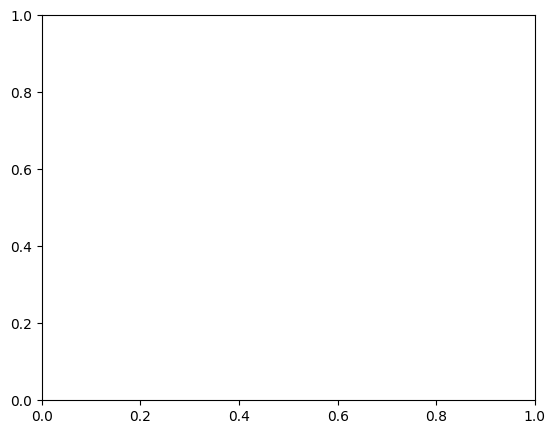

In [ ]:
# ==============================================
# Evaluation & Visualization
# ==============================================
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
# Final evaluation
results = model.evaluate(test_dataset, verbose=0)
print(f"\nFinal Metrics:")
print(f"Test Accuracy: {results[1]*100:.2f}%")
print(f"Top-3 Accuracy: {results[2]*100:.2f}%")


Final Metrics:
Test Accuracy: 86.50%
Top-3 Accuracy: 99.60%


In [ ]:
model.save('PDD_completemodel.h5')  # Save as HDF5 format for easy loading

print("Model training and saving complete.")